In [165]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lmfit as lm
from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy.integrate import quad
from scipy.optimize import minimize #optimization

In [166]:
dt = 0.00001 # what is dt? is the sampling period in the time-domain
length = 1000 # length of what? length of the intensity signal
T = length*dt # time that signal covers
D = 10000 # diffusion coefficient
sigma = 2 # standard deviation
L = 10
N = 30
T

0.01

In [167]:
# initial positions
pos1 = 2*L*np.random.random(size=(N,))-L

In [168]:
# random walks
steps = np.random.normal(loc=0,scale=np.sqrt(2*D*dt),size=(N,length))
x = np.column_stack((pos1,steps))
path = np.mod(np.cumsum(x,axis=1),2*L)-L

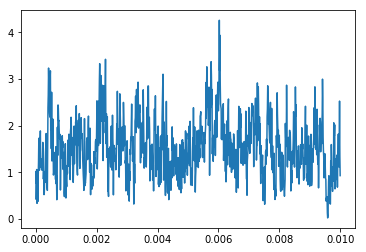

In [169]:
# simulating 2D gaussian illumination with variance = 1
intensity = norm.pdf(path,loc=0)
intensity = np.sum(intensity,axis=0) # moving to 1 dimension
tt = np.arange(length+1)*dt # time-axis t[-1]=T
plt.plot(tt,intensity)

131

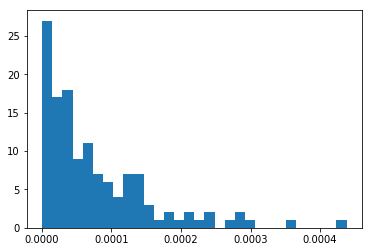

In [170]:
intensity_interp = interp1d(tt,intensity*10000)
t = 0
delta_t_list=[]
while t < tt[-1]:
    current_int = intensity_interp(t)
    delta_t = np.random.exponential(1/current_int)
    delta_t_list.append(delta_t)
    t = t + delta_t
plt.hist(delta_t_list,bins=30)
len(delta_t_list)

In [171]:
delta_t_list = np.array(delta_t_list)
delta_t_list.sort(axis=0)

In [172]:
t = delta_t_list # time array
N = len(t)

In [173]:
# likelihood function
def p_dt_integrant(pos,flux):
    f = np.exp(-flux*pos)/np.sqrt(-np.log(pos))
    return f

In [182]:
def objective(I0):
    flux = I0*t
    sol = np.array([quad(p_dt_integrant,0,1,args=(f))[0] for f in flux])
    obj = -N*np.log(I0)-np.sum(np.log(sol))
    return obj

In [183]:
res = minimize(objective,10,options={'disp':True})
I0_opt = res.x[0]
print('I0 =',str(I0_opt),'minimizes the likelihood')

         Current function value: -1278.650814
         Iterations: 21
         Function evaluations: 176
         Gradient evaluations: 55
I0 = 49070.385971196694 minimizes the likelihood


C:\Users\mebra\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


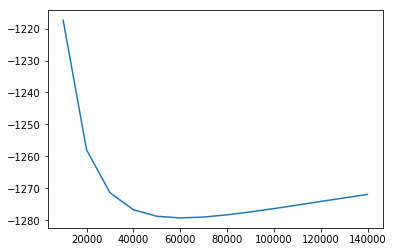

In [184]:
I0 = 0
tt = []
s = []
for i in range(15):
    tt.append(I0)
    flux = I0*delta_t_list
    f = np.array([quad(p_dt_int,0,1,args=(f))[0] for f in flux])
    likelihood = -N*np.log(I0)-np.sum(np.log(f))
    s.append(likelihood)
    I0 = I0+10000
plt.plot(tt,s)

In [185]:
# minimization using BFGS
p = lm.Parameters()
p.add('I0',value=10)
N = len(delta_t_list)
def objective(p):
    flux = p['I0']*delta_t_list
    sol = np.array([quad(p_dt_integrant,0,1,args=(f))[0] for f in flux])
    obj = -N*np.log(p['I0'])-np.sum(np.log(sol))
    return obj
mini = lm.Minimizer(objective,p,nan_policy='omit')
out1 = mini.minimize(method='BFGS')
lm.report_fit(out1.params, min_correl=0.5)

[[Variables]]
    I0:  49070.3860 (init = 10)


C:\Users\mebra\Anaconda3\lib\site-packages\lmfit\minimizer.py:335: RuntimeWarning: divide by zero encountered in double_scalars
  self.redchi = self.chisqr / self.nfree
